In [84]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

In [86]:
data=pd.read_csv("D:/New 4th project/Swiggyproject/swiggy.csv")

In [87]:
data.head()

,id,name,city,rating,rating_count,cost,cuisine,lic_no,link,address,menu
0,567335,AB FOODS POINT,Abohar,--,Too Few Ratings,₹ 200,"Beverages,Pizzas",22122652000138,https://www.swiggy.com/restaurants/ab-foods-po...,"AB FOODS POINT, NEAR RISHI NARANG DENTAL CLINI...",Menu/567335.json
1,531342,Janta Sweet House,Abohar,4.4,50+ ratings,₹ 200,"Sweets,Bakery",12117201000112,https://www.swiggy.com/restaurants/janta-sweet...,"Janta Sweet House, Bazar No.9, Circullar Road,...",Menu/531342.json
2,158203,theka coffee desi,Abohar,3.8,100+ ratings,₹ 100,Beverages,22121652000190,https://www.swiggy.com/restaurants/theka-coffe...,"theka coffee desi, sahtiya sadan road city",Menu/158203.json
3,187912,Singh Hut,Abohar,3.7,20+ ratings,₹ 250,"Fast Food,Indian",22119652000167,https://www.swiggy.com/restaurants/singh-hut-n...,"Singh Hut, CIRCULAR ROAD NEAR NEHRU PARK ABOHAR",Menu/187912.json
4,543530,GRILL MASTERS,Abohar,--,Too Few Ratings,₹ 250,"Italian-American,Fast Food",12122201000053,https://www.swiggy.com/restaurants/grill-maste...,"GRILL MASTERS, ADA Heights, Abohar - Hanumanga...",Menu/543530.json


In [88]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148541 entries, 0 to 148540
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            148541 non-null  int64 
 1   name          148455 non-null  object
 2   city          148541 non-null  object
 3   rating        148455 non-null  object
 4   rating_count  148455 non-null  object
 5   cost          148410 non-null  object
 6   cuisine       148442 non-null  object
 7   lic_no        148312 non-null  object
 8   link          148541 non-null  object
 9   address       148455 non-null  object
 10  menu          148541 non-null  object
dtypes: int64(1), object(10)
memory usage: 12.5+ MB


In [89]:
data.shape

(148541, 11)

In [90]:
data[["name","city","cuisine","link","address"]] = data[["name","city","cuisine","link","address"]].astype(str)

In [91]:
data.dtypes

id               int64
name            object
city            object
rating          object
rating_count    object
cost            object
cuisine         object
lic_no          object
link            object
address         object
menu            object
dtype: object

In [92]:
data["name"] = data["name"].astype(str)
data["city"] = data["city"].astype(str)
data["cuisine"] = data["cuisine"].astype(str)
data["link"] = data["link"].astype(str)
data["address"] = data["address"].astype(str)


In [93]:
data.dtypes

id               int64
name            object
city            object
rating          object
rating_count    object
cost            object
cuisine         object
lic_no          object
link            object
address         object
menu            object
dtype: object

In [94]:
print(data.duplicated().sum())

0


In [95]:
data.isnull().sum()

id                0
name              0
city              0
rating           86
rating_count     86
cost            131
cuisine           0
lic_no          229
link              0
address           0
menu              0
dtype: int64

In [96]:
# Critical categorical feature; dropping missing rows is better.
# data= data.dropna(subset=["name","cuisine", "address"])

In [97]:
# Drop columns that are not useful
data.drop(columns=["lic_no","menu","id"], inplace=True)

In [98]:
data["cost"] = data["cost"].str.replace("₹", "").str.replace(",", "").str.strip()
data["cost"] = pd.to_numeric(data["cost"], errors="coerce")

In [99]:
# Impute missing values for 'cost' using median per city
data['cost'] = data.groupby('city')['cost'].transform(lambda x: x.fillna(x.median()))

In [100]:
# Define rating count ranges
rating_map = {
    "Too Few Ratings": 10,   # Assume a small default count
    "20+ ratings": 35,       # Average of 21-50
    "50+ ratings": 75,       # Average of 51-100
    "100+ ratings": 300,     # Average of 101-500
    "500+ ratings": 750,     # Average of 500-1000
    "1K+ ratings": 2500,     # Average of 1001-5000
    "5K+ ratings": 7500,     # Average of 5001-10000
    "10K+ ratings": 12500    # Average of 10001-15000
}

# Convert 'rating_count' to numeric using mapping
data["rating_count"] = data["rating_count"].map(rating_map)

# If there are still missing values, fill with median of the city
data["rating_count"] = data.groupby("city")["rating_count"].transform(lambda x: x.fillna(x.median()))

# Final check
print(data["rating_count"].isnull().sum())  # Should be 0
print(data.head())

0
                name    city rating  rating_count   cost  \
0     AB FOODS POINT  Abohar     --          10.0  200.0   
1  Janta Sweet House  Abohar    4.4          75.0  200.0   
2  theka coffee desi  Abohar    3.8         300.0  100.0   
3          Singh Hut  Abohar    3.7          35.0  250.0   
4      GRILL MASTERS  Abohar     --          10.0  250.0   

                      cuisine  \
0            Beverages,Pizzas   
1               Sweets,Bakery   
2                   Beverages   
3            Fast Food,Indian   
4  Italian-American,Fast Food   

                                                link  \
0  https://www.swiggy.com/restaurants/ab-foods-po...   
1  https://www.swiggy.com/restaurants/janta-sweet...   
2  https://www.swiggy.com/restaurants/theka-coffe...   
3  https://www.swiggy.com/restaurants/singh-hut-n...   
4  https://www.swiggy.com/restaurants/grill-maste...   

                                             address  
0  AB FOODS POINT, NEAR RISHI NARANG DENTAL CL

In [101]:
data["rating"] = pd.to_numeric(data["rating"], errors="coerce")  # Ensure numeric type
data["rating"] = data["rating"].fillna(data["rating"].mean())  # Fill NaN with mean

In [102]:
data.isnull().sum()

name            0
city            0
rating          0
rating_count    0
cost            0
cuisine         0
link            0
address         0
dtype: int64

In [103]:
print(data["cuisine"].unique())


['Beverages,Pizzas' 'Sweets,Bakery' 'Beverages' ... 'Biryani,Thai'
 'South American,Andhra' 'Barbecue,Italian-American']


In [104]:
print(data["cuisine"].nunique())

2133


In [105]:
# Save cleaned data
data.to_csv("D:/New 4th project/Swiggyproject/cleaned_df.csv")

In [106]:
data.shape

(148541, 8)

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

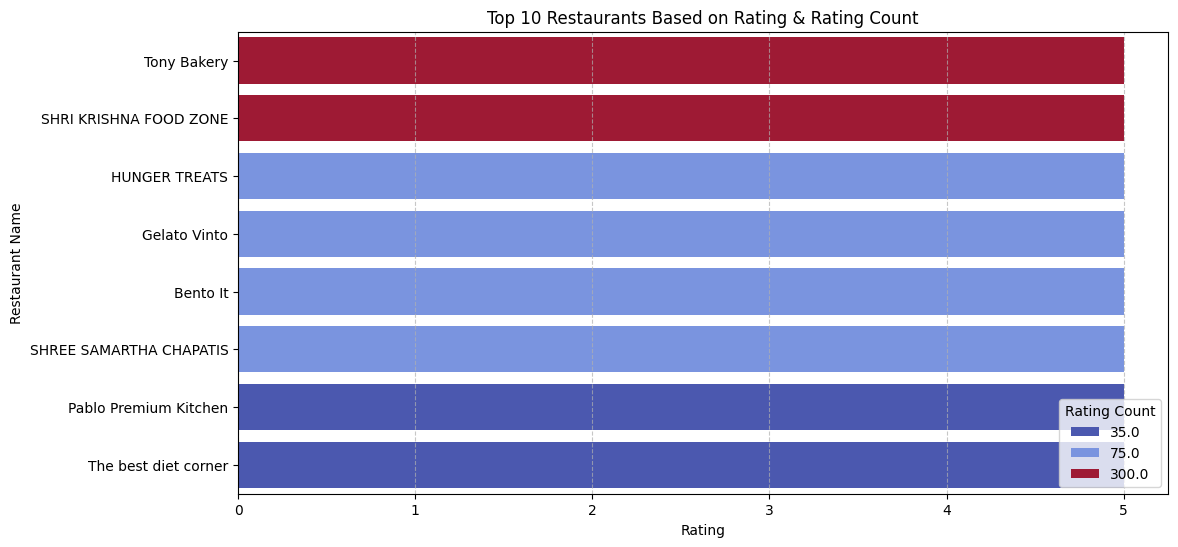

In [108]:
# Select top 10 restaurants based on rating and rating count
top_restaurants = data.sort_values(by=["rating", "rating_count"], ascending=[False, False]).head(10)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x="rating", y="name", data=top_restaurants, hue="rating_count", palette="coolwarm", dodge=False)

plt.xlabel("Rating")
plt.ylabel("Restaurant Name")
plt.title("Top 10 Restaurants Based on Rating & Rating Count")
plt.legend(title="Rating Count", loc="lower right")
plt.grid(axis="x", linestyle="--", alpha=0.7)

plt.show()

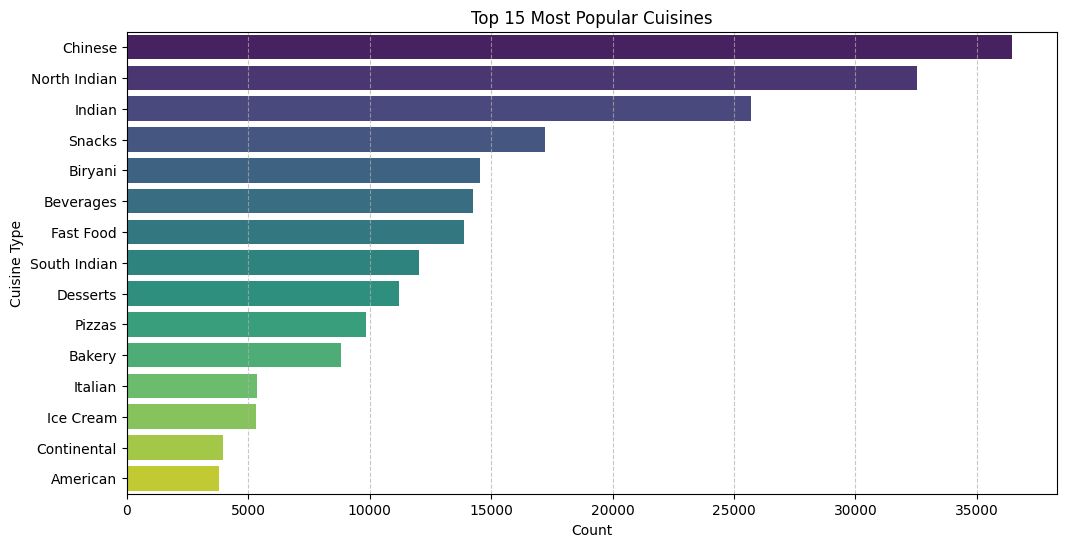

In [109]:
from collections import Counter

# Flatten the cuisine list
cuisine_list = [item.strip() for sublist in data["cuisine"].dropna().str.split(",") for item in sublist]

# Count occurrences
cuisine_counts = Counter(cuisine_list)
top_cuisines = dict(cuisine_counts.most_common(15))

# Convert to DataFrame for better handling
cuisine_df = pd.DataFrame({"Cuisine": list(top_cuisines.keys()), "Count": list(top_cuisines.values())})

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=cuisine_df, x="Count", y="Cuisine", hue="Cuisine", dodge=False, palette="viridis", legend=False)

plt.xlabel("Count")
plt.ylabel("Cuisine Type")
plt.title("Top 15 Most Popular Cuisines")
plt.grid(axis="x", linestyle="--", alpha=0.7)

plt.show()

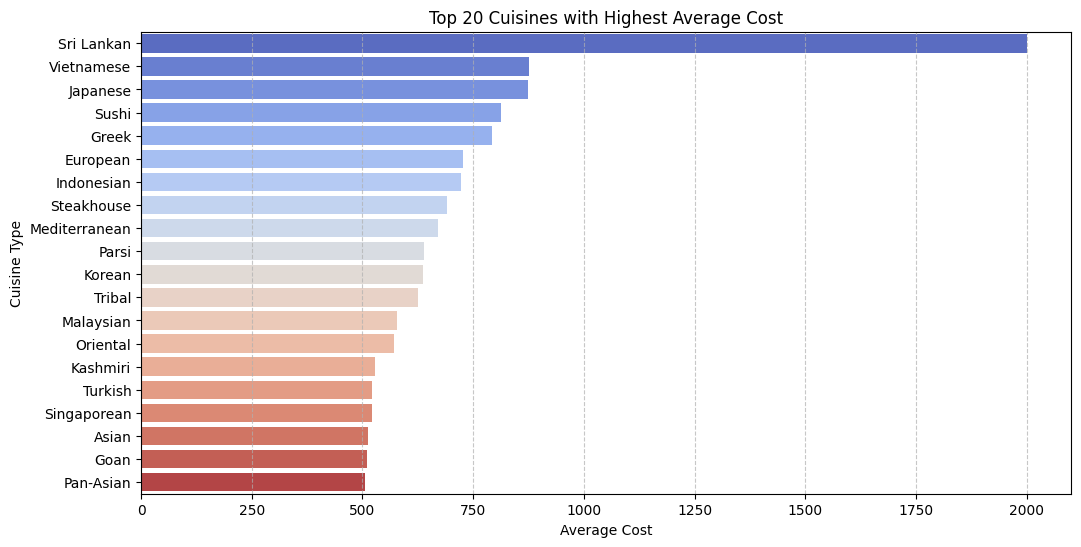

In [110]:
# Split and explode cuisine values into individual rows
cuisine_exploded = data.assign(cuisine=data["cuisine"].str.split(",")).explode("cuisine")
cuisine_exploded["cuisine"] = cuisine_exploded["cuisine"].str.strip()  # Remove spaces

# Group by cuisine and calculate average cost
cuisine_avg_cost = cuisine_exploded.groupby("cuisine")["cost"].mean().sort_values(ascending=False).head(20)

# Convert to DataFrame to allow using 'hue'
cuisine_avg_cost_df = cuisine_avg_cost.reset_index()
cuisine_avg_cost_df.columns = ["cuisine", "average_cost"]

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=cuisine_avg_cost_df, x="average_cost", y="cuisine", hue="cuisine", palette="coolwarm", legend=False)

plt.xlabel("Average Cost")
plt.ylabel("Cuisine Type")
plt.title("Top 20 Cuisines with Highest Average Cost")
plt.grid(axis="x", linestyle="--", alpha=0.7)

plt.show()

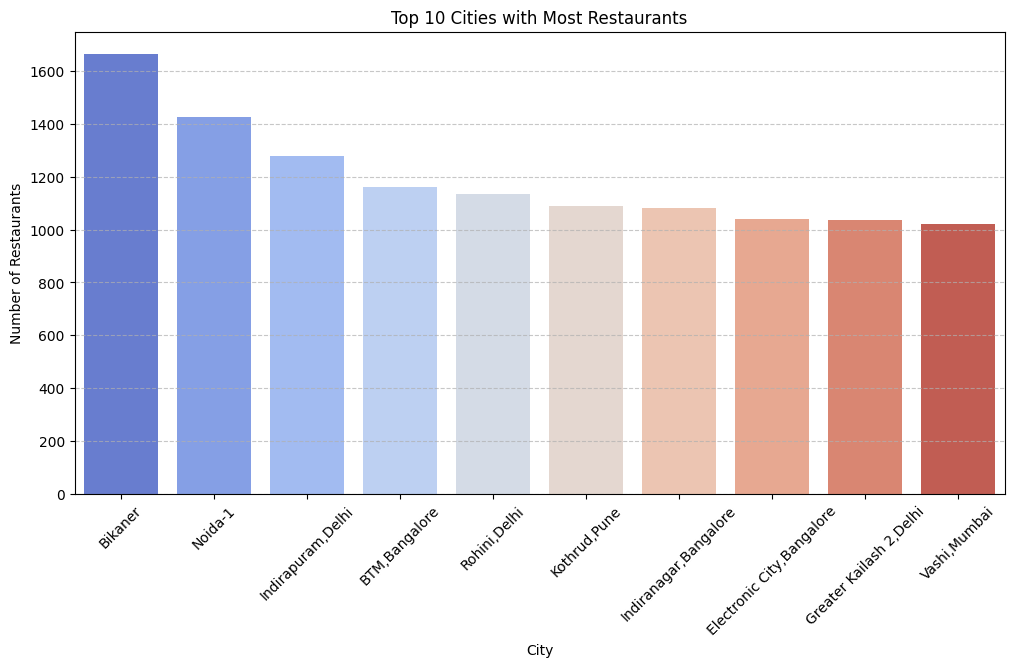

In [111]:
# Count the number of restaurants per city
city_counts = data["city"].value_counts().head(10)

# Convert to DataFrame to assign 'hue'
city_counts_df = city_counts.reset_index()
city_counts_df.columns = ["city", "restaurant_count"]

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=city_counts_df, x="city", y="restaurant_count", hue="city", palette="coolwarm", legend=False)

plt.xlabel("City")
plt.ylabel("Number of Restaurants")
plt.title("Top 10 Cities with Most Restaurants")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()


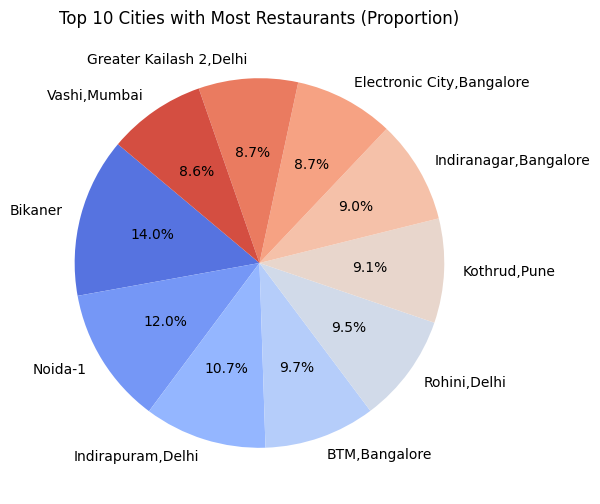

In [112]:
plt.figure(figsize=(10, 6))

# Plot Pie Chart
plt.pie(city_counts.values, labels=city_counts.index, autopct="%1.1f%%", colors=sns.color_palette("coolwarm", 10), startangle=140)

plt.title("Top 10 Cities with Most Restaurants (Proportion)")
plt.show()

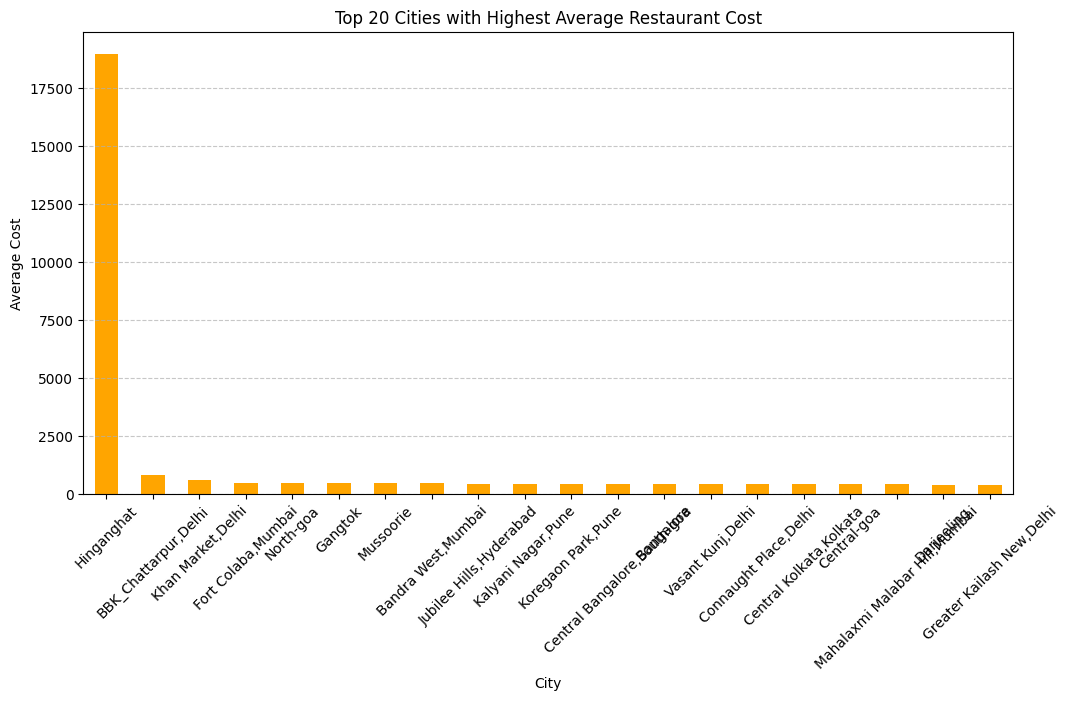

In [113]:
city_avg_cost = data.groupby("city")["cost"].mean().sort_values(ascending=False).head(20)

plt.figure(figsize=(12, 6))
city_avg_cost.plot(kind="bar", color="orange")

plt.xlabel("City")
plt.ylabel("Average Cost")
plt.title("Top 20 Cities with Highest Average Restaurant Cost")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

In [115]:
df = pd.read_csv("D:/New 4th project/Swiggyproject/cleaned_df.csv")

In [116]:
# Initialize encoders and scaler
name_encoder = LabelEncoder()
cuisine_encoder = LabelEncoder()
city_encoder = OneHotEncoder(handle_unknown="ignore")

# Standardize numerical features
rating_scaler = StandardScaler()
cost_scaler = StandardScaler()

# One-Hot Encoding for city

# One-Hot Encoding for city
city_encoded = city_encoder.fit_transform(df[["city"]]).toarray()  # Convert to dense array
city_encoded_df = pd.DataFrame(city_encoded, columns=city_encoder.get_feature_names_out(["city"]))

# Label Encoding for name and cuisine

df["name_encoded"] = name_encoder.fit_transform(df["name"])
df["cuisine_encoded"] = cuisine_encoder.fit_transform(df["cuisine"])

# Apply StandardScaler separately

df["rating_scaled"] = rating_scaler.fit_transform(df[["rating"]])
df["cost_scaled"] = cost_scaler.fit_transform(df[["cost"]])

In [117]:
# Combine all encoded and scaled features

encoded_df = pd.concat([
  df.drop(["city", "name", "cuisine", "rating", "cost","link","address","rating_count"], axis=1),
    city_encoded_df
], axis=1)

In [118]:
encoded_df.head()

,Unnamed: 0,name_encoded,cuisine_encoded,rating_scaled,cost_scaled,"city_Abids & Koti,Hyderabad",city_Abohar,"city_Adajan,Surat",city_Adilabad,city_Adityapur,...,city_Washim,"city_West Chd,Chandigarh","city_West Marredpally,Hyderabad","city_Whitefield,Bangalore",city_Yamuna-nagar,city_Yavatmal,"city_Yelahanka,Bangalore","city_Yeshwanthpur,Bangalore","city_Zirakpur,Chandigarh","city_sohna road,Gurgaon"
0,0,1583,328,-4.502735e-15,-0.109949,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,47417,1983,1.708596e+00,-0.109949,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,112644,289,-3.192560e-01,-0.235518,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,90303,796,-6.572313e-01,-0.047165,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,34938,1166,-4.502735e-15,-0.047165,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [119]:
encoded_df.shape

(148541, 826)

In [120]:
encoded_df.dtypes

Unnamed: 0                       int64
name_encoded                     int64
cuisine_encoded                  int64
rating_scaled                  float64
cost_scaled                    float64
                                ...   
city_Yavatmal                  float64
city_Yelahanka,Bangalore       float64
city_Yeshwanthpur,Bangalore    float64
city_Zirakpur,Chandigarh       float64
city_sohna road,Gurgaon        float64
Length: 826, dtype: object

In [121]:
# Save all encoders and scaler in ONE pickle file
encoders_scaler = {
    "name_encoder": name_encoder,
    "city_encoder": city_encoder,
    "cuisine_encoder": cuisine_encoder,
    "rating_scaler": rating_scaler,
    "cost_scaler": cost_scaler
}

with open("encoders_scaler3.pkl", "wb") as f:
    pickle.dump(encoders_scaler, f)

In [123]:
# Save encoded dataset
encoded_df.to_csv("D:/New 4th project/Swiggyproject/encoded_data4.csv", index=True)

In [124]:
original_df = pd.read_csv("D:/New 4th project/Swiggyproject/cleaned_df.csv")  # Load original dataset for mapping results
     

In [125]:
# Clustering - Finding Optimal K
inertia = []
K_range = range(2, 10)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(encoded_df)
    inertia.append(kmeans.inertia_)

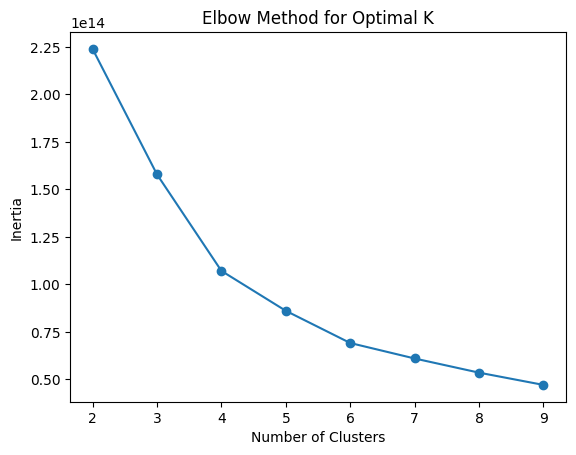

In [128]:
# Plot Elbow Method
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

In [127]:
# Apply K-Means Clustering
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
encoded_df["cluster"] = kmeans.fit_predict(encoded_df)

# Save the K-Means model
with open("kmeans_model.pkl", "wb") as f:
    pickle.dump(kmeans, f)
     

In [129]:
# Function to recommend restaurants using K-Means

def recommend_kmeans(restaurant_index, top_n=5):
    cluster_label = encoded_df.loc[restaurant_index, "cluster"]
    similar_restaurants = encoded_df[encoded_df["cluster"] == cluster_label].index.tolist()
    similar_restaurants.remove(restaurant_index)  # Exclude input restaurant
    return similar_restaurants[:top_n]

In [130]:
# Function to map recommendations back to the original dataset
def map_results(recommended_indices):
    return original_df.iloc[recommended_indices][["name", "city", "cuisine", "rating", "cost"]]

In [131]:
# Example usage
restaurant_index = 10  # Choose an index from the dataset
kmeans_recommendations = map_results(recommend_kmeans(restaurant_index))

In [132]:
print("K-Means Recommendations:")
print(kmeans_recommendations)

K-Means Recommendations:
                        name    city                     cuisine    rating  \
0             AB FOODS POINT  Abohar            Beverages,Pizzas  3.894461   
4              GRILL MASTERS  Abohar  Italian-American,Fast Food  3.894461   
8   Hinglaj Kachori Bhandhar  Abohar                Snacks,Chaat  4.200000   
14         Bharawan Da Dhaba  Abohar                      Indian  4.400000   
19                FOODY MOOD  Abohar           Fast Food,Chinese  4.700000   

     cost  
0   200.0  
4   250.0  
8   100.0  
14  300.0  
19  300.0  
